# MU4MEN01 - Introduction à l'optimisation

## Projet : Dimensionnement de stockage embarqué dans un tramway

### Objectifs du projet :

Lors de ce projet d'optimisation, nous essaierons de :
- Mettre en œuvre une démarche d’optimisation pour la conception d’un système,
- Comprendre le principe de l’alimentation électrique des tramways,
- Découvrir l’optimisation multi-critères et le concept d’optimalité au  sens de Pareto,
- Et mettre en œuvre l’algorithme génétique `NSGA-2`. 
___

### Étudiants : Jacques GUÉRIN (21112101) - William WU (21107936)
- mail 1 : jacques.guerin@etu.sorbonne-universite.fr
- mail 2 : William.Wu@etu.sorbonne-universite.fr
___

### Import des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Données initiales de notre problème

In [2]:
### Données initiales

V_s = 790           # Tension nominale (V)
R_s = 33e-3         # Résistance interne (ohms)
rho_lac = 131e-6    # Résistance linéique LAC (ohms/m)
rho_rail = 18e-6    # Résistance linéique rail (ohms/m)
M = 70_000          # Masse du train (kg)
P_bord = 35_000     # Consommation électrique à bord (W)
rendement = 0.8     # Rendement global

# 2.1 Mise en place du modèle du système

Longueur de la ligne : 1246.44348144531 m
Simulation avec une capacité de batterie de 5.0 MJ
Simulation sans batterie...
Affichage des résultats...


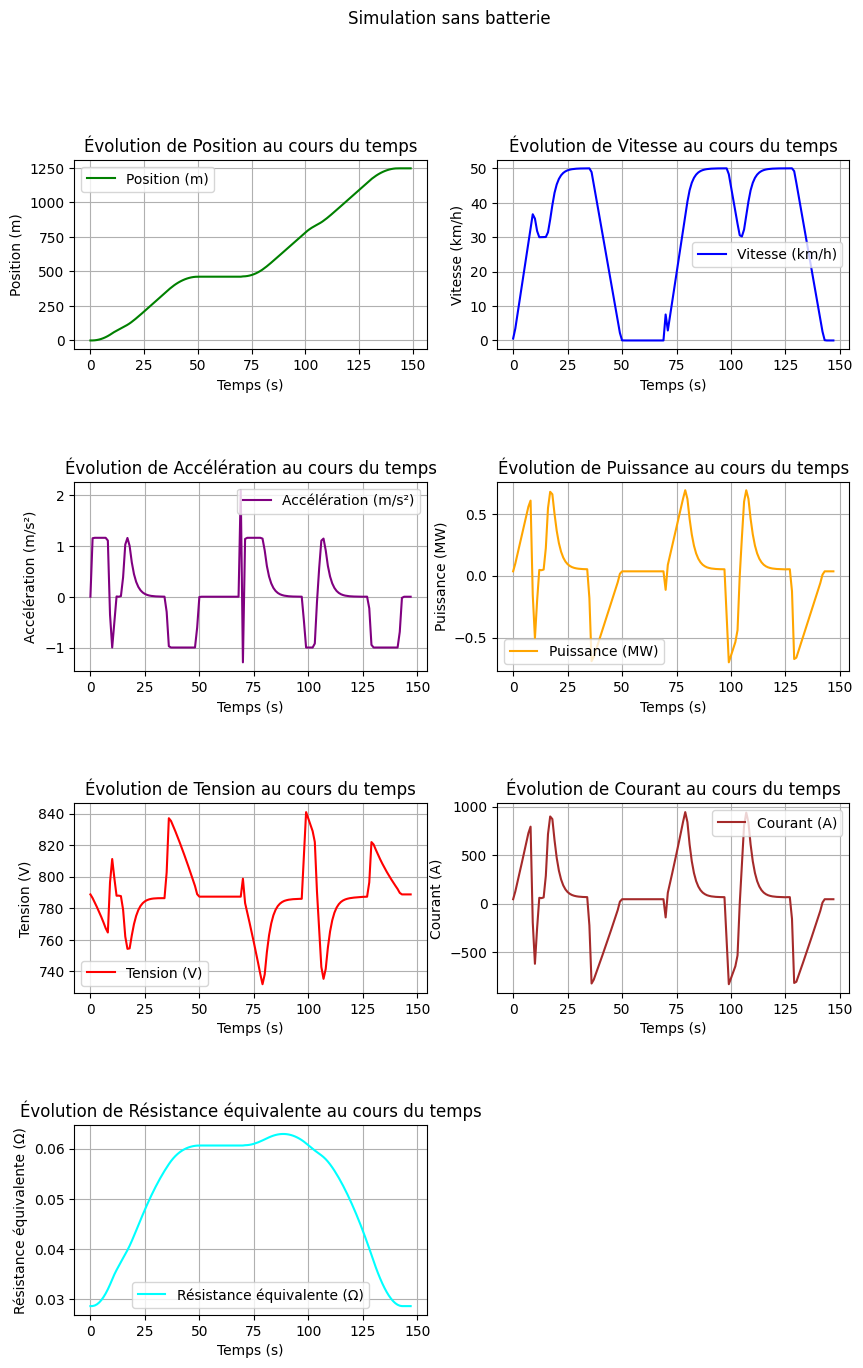

Simulation avec batterie...
Affichage des résultats...


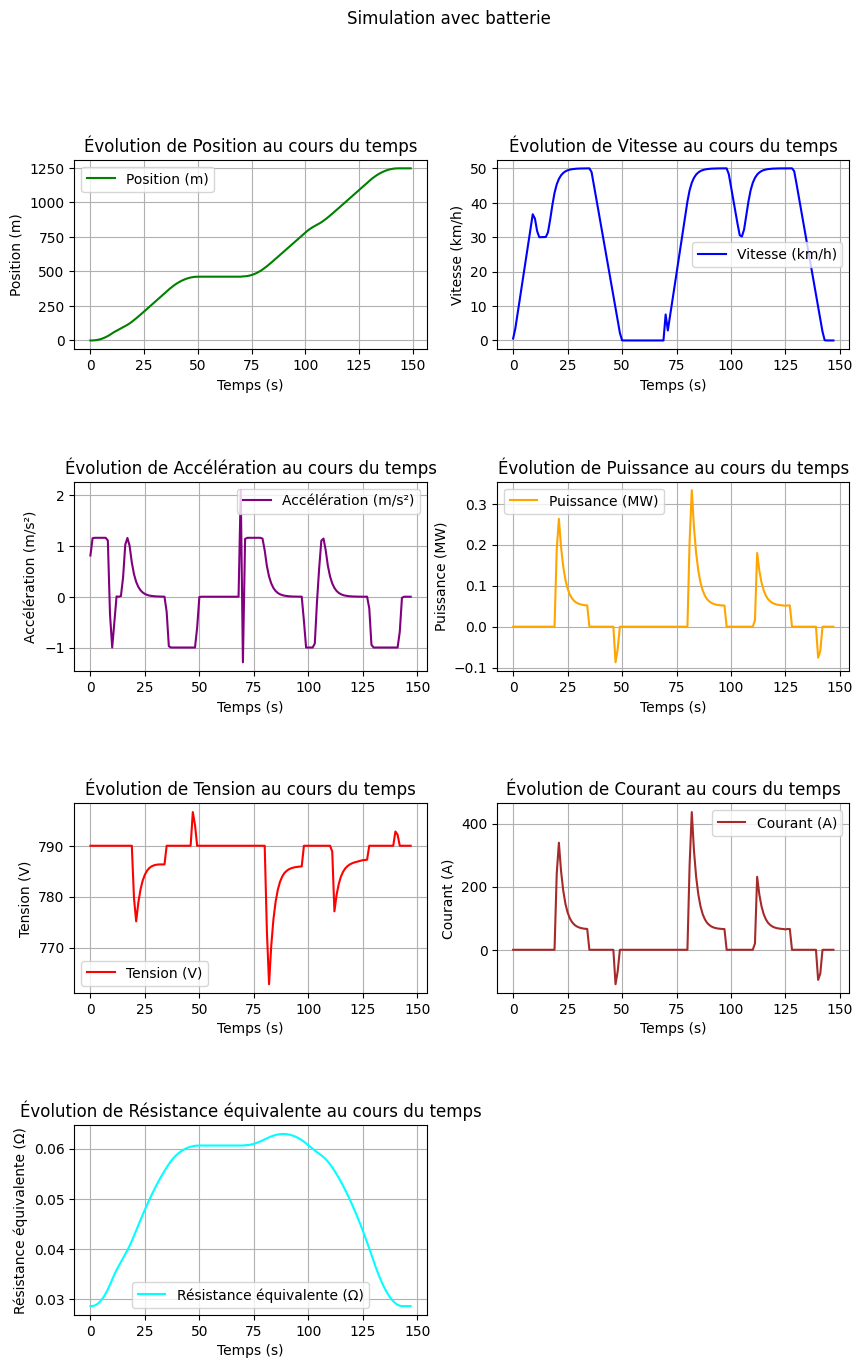

In [3]:
### Création d'une classe pour optimiser les tracés:

class Data:
    def __init__(self, temps, valeurs, nom, unite, couleur):
        """
        Initialisation de l'objet Data.

        Arguments :
        - temps (array) : Les valeurs de temps associées.
        - valeurs (array) : Les valeurs à tracer.
        - nom (str) : Le nom des données (ex. 'Vitesse', 'Position').
        - unite (str) : L'unité des données (ex. 'm/s', 'V').
        - couleur (str) : Couleur de la courbe (par défaut : "blue").
        """
        self.temps = temps
        self.valeurs = valeurs
        self.nom = nom
        self.unite = unite
        self.couleur = couleur

    def tracer(self):
        """
        Trace les données avec un titre et des étiquettes adaptés.
        """
        plt.plot(self.temps, self.valeurs, label=f"{self.nom} ({self.unite})", color=self.couleur)
        plt.xlabel("Temps (s)")
        plt.ylabel(f"{self.nom} ({self.unite})")
        plt.title(f"Évolution de {self.nom} au cours du temps")
        plt.legend()
        plt.grid()

    def afficher(self):
        """
        Affiche directement le tracé des données.
        """
        self.tracer()
        plt.show()

### Les fonctions de calcul

def calcul_resistance(distance, rho):
    '''Calcul de la résistance entre sous-station et train.'''
    return rho * distance

def puissance_mecanique(vitesse, acceleration, alpha):
    '''Calcule de la puissance mécanique nécessaire.'''
    # Coefficients de résistance
    A = 780
    A_t = 6.4
    B = 0
    B_t = 0.14
    C = 0.3634
    C_t = 0

    F_resistance = (A + A_t * M / 1_000) + (B + B_t * M / 1_000) * vitesse + (C + C_t * M / 1_000) * vitesse**2
    F_gravite = M * 9.81 * np.sin(np.radians(alpha))
    F_motrice = F_resistance + F_gravite + (M * acceleration)
    return F_motrice * vitesse

def puissance_electrique(p_mec):
    '''Calcul de la puissance électrique à partir de la mécanique.'''
    return p_mec * rendement

def tension_train(P_train, R_eq):
    '''Calcul de Tension aux bornes du train.
    Résolution de l'équation : V^2 - V*V_s + R_eq*P_train = 0.'''
    delta = V_s**2 - 4 * R_eq * P_train
    # Pour un delta négatif pas de solution
    if delta < 0:
        return 0
    v_1 = (V_s + np.sqrt(delta)) / 2
    return v_1

### Train en déplacement

def charger_donnees_train(fichier):
    """Charge les données de déplacement du train à partir d'un fichier texte.
    Arguments: 
        fichier (str): Chemin vers le fichier `marche.txt`.
    Renvoie:
        tuple (2 tableaux numpy): les temps et les positions."""
    try:
        data = np.loadtxt(fichier, delimiter='\t', dtype=float)
        temps = data[:, 0]  # Première colonne : temps
        positions = data[:, 1]  # Deuxième colonne : positions
        return temps, positions
    except Exception as e:
        print(f"Erreur lors du chargement des données : {e}")
        return None, None

def calcul_resistances(position, longueur_ligne):
    '''Calcul des résistances lorsque le train est en déplacement.'''
    distance_1 = position
    distance_2 = longueur_ligne - position
    R1 = calcul_resistance(distance_1, rho_lac + rho_rail) + R_s
    R2 = calcul_resistance(distance_2, rho_lac + rho_rail) + R_s
    return R1, R2

### Simulation sans batterie

def simulation_sans_batterie(temps, positions, longueur_ligne):
    """
    Fait la simulation du système sans batterie.
    
    Arguments :
        temps (array): Tableau des temps.
        positions (array): Tableau des positions.
        longueur_ligne (float): Longueur totale de la ligne.
    
    Retourne :
        tuple: Listes des tensions et des courants.
    """
    tensions = []
    courants = []
    puissances = []
    vitesses = []
    accelerations = []
    resistances_eq = []

    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Résistances
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1*R2) / (R1+R2)
        resistances_eq.append(R_eq)

        # Calcul de la vitesse (différence entre deux positions successives)
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]
        
        vitesse_1 = (positions[i+1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i+2] - positions[i+1]) / dt2 if dt2 != 0 else 0

        acceleration = (vitesse_2-vitesse_1) / (temps[i + 2] - temps[i + 1]) if i > 0 else 0

        # Puissance mécanique et électrique
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha = 0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Tension aux bornes du train
        V_train = tension_train(P_train, R_eq)
        if V_train is None:
            raise ValueError(f"Pas de solution pour la tension au temps {temps[i]}")

        # Stocker les résultats
        vitesses.append(vitesse_1*3.6)          # Conversion en km/h
        accelerations.append(acceleration)
        tensions.append(V_train)
        puissances.append(P_train/(10**6))      # Conversion en MW
        courants.append(P_train / V_train)

    return resistances_eq, vitesses, accelerations, tensions, puissances, courants

### Simulation avec batterie

def simulation_avec_batterie(temps, positions, longueur_ligne, capacite_batterie):
    """
    Simule le système avec batterie.

    Arguments :
        temps (array): Tableau des temps.
        positions (array): Tableau des positions.
        longueur_ligne (float): Longueur totale de la ligne.
        capacite_batterie (float): Capacité maximale de la batterie (en joules).

    Retourne :
        tuple: Listes des tensions, courants, vitesses, accélérations, puissances et résistances.
    """
    tensions = []
    courants = []
    puissances = []
    vitesses = []
    accelerations = []
    resistances_eq = []

    energie_batterie = capacite_batterie  # État initial de la batterie (plein)
    
    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Résistances
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1 * R2) / (R1 + R2)
        resistances_eq.append(R_eq)

        # Calcul de la vitesse (différence entre deux positions successives)
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]
        
        vitesse_1 = (positions[i+1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i+2] - positions[i+1]) / dt2 if dt2 != 0 else 0

        # Calcul de l'accélération
        acceleration = (vitesse_2 - vitesse_1) / (temps[i + 2] - temps[i + 1]) if dt2 != 0 else 0

        # Puissance mécanique et électrique
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha=0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Gestion de la batterie
        if P_train > 0:  # Le train consomme de la puissance
            if energie_batterie > 0:  # Si la batterie n'est pas vide
                # Fournir de l'énergie par la batterie
                P_batt = min(energie_batterie / dt1, P_train)  # Puissance max que la batterie peut fournir
                P_train -= P_batt  # Réduction de la puissance demandée à la LAC
                energie_batterie -= P_batt * dt1  # Mise à jour de l'énergie de la batterie
        elif P_train < 0:  # Le train freine (P_train négative)
            if energie_batterie < capacite_batterie:  # Si la batterie n'est pas pleine
                # Stocker l'énergie de freinage
                P_batt = min(-P_train, (capacite_batterie - energie_batterie) / dt1)
                energie_batterie += P_batt * dt1  # Mise à jour de l'énergie stockée
                P_train += P_batt  # Réduction de l'énergie dissipée dans le rhéostat

        # Tension aux bornes du train
        V_train = tension_train(P_train, R_eq)
        if V_train is None:
            raise ValueError(f"Pas de solution pour la tension au temps {temps[i]}")

        # Stocker les résultats
        vitesses.append(vitesse_1 * 3.6)  # Conversion en km/h
        accelerations.append(acceleration)
        tensions.append(V_train)
        puissances.append(P_train / (10**6))  # Conversion en MW
        courants.append(P_train / V_train)

    return resistances_eq, vitesses, accelerations, tensions, puissances, courants

### Affichage des résultats

def plot_all(fig_name, temps, positions, vitesses, accelerations, puissances, tensions, courants, resistances_eq):
    """
    Trace tous les graphiques pour les données fournies.
    """
    plt.figure(num=fig_name, figsize=(10, 15))
    plt.suptitle(fig_name)
    plt.subplots_adjust(hspace=0.7)

    # Création des objets Data pour chaque série de données
    donnees = [
        Data(temps[:len(positions)], positions, "Position", "m", couleur="green"),
        Data(temps[:len(vitesses)], vitesses, "Vitesse", "km/h", couleur="blue"),
        Data(temps[:len(accelerations)], accelerations, "Accélération", "m/s²", couleur="purple"),
        Data(temps[:len(puissances)], puissances, "Puissance", "MW", couleur="orange"),
        Data(temps[:len(tensions)], tensions, "Tension", "V", couleur="red"),
        Data(temps[:len(courants)], courants, "Courant", "A", couleur="brown"),
        Data(temps[:len(resistances_eq)], resistances_eq, "Résistance équivalente", "Ω", couleur="cyan")
    ]

    # Boucle pour tracer chaque série de données
    for i, data in enumerate(donnees):
        plt.subplot(4, 2, i + 1)
        data.tracer()

    plt.show()

def main():
    # 1. Chargement des données
    fichier_donnees = "marche.txt"
    temps, positions = charger_donnees_train(fichier_donnees)
    
    if temps is None or positions is None:
        print("Erreur : Impossible de charger les données du fichier.")
        return

    # Limiter l'échantillonnage à 150 points
    temps = temps[:150]
    positions = positions[:150]

    # 2. Définir les paramètres de la ligne de tramway
    longueur_ligne = max(positions)  # Longueur totale de la ligne (en mètres)
    capacite_batterie = 5e6  # Capacité de la batterie (en joules, ici 5 MJ)

    print(f"Longueur de la ligne : {longueur_ligne} m")
    print(f"Simulation avec une capacité de batterie de {capacite_batterie / 1e6} MJ")

    # 3. Simulation sans batterie
    print("Simulation sans batterie...")
    try:
        resistances_eq_sb, vitesses_sb, accelerations_sb, tensions_sb, puissances_sb, courants_sb = simulation_sans_batterie(temps, positions, longueur_ligne)
    except Exception as e:
        print(f"Erreur pendant la simulation sans batterie : {e}")
        return
    
    print("Affichage des résultats...")
    plot_all("Simulation sans batterie", temps, positions, vitesses_sb, accelerations_sb, puissances_sb, tensions_sb, courants_sb, resistances_eq_sb)

    # 4. Simulation avec batterie
    print("Simulation avec batterie...")
    try:
        resistances_eq_ab, vitesses_ab, accelerations_ab, tensions_ab, puissances_ab, courants_ab = simulation_avec_batterie(temps, positions, longueur_ligne, capacite_batterie)
    except Exception as e:
        print(f"Erreur pendant la simulation avec batterie : {e}")
        return
    
    print("Affichage des résultats...")
    plot_all("Simulation avec batterie", temps, positions, vitesses_ab, accelerations_ab, puissances_ab, tensions_ab, courants_ab, resistances_eq_ab)

if __name__ == "__main__":
    main()

# 2.2 Dimensionnement du système de stockage

### Méthode de Monte-Carlo

**Objectif** : minimiser $V_{sst} - V_{train}$

Pour répondre à cet objectif nous avons pris en compte deux éléments:
- La capacité en énergie de la batterie
- Et la chute de tension maximale

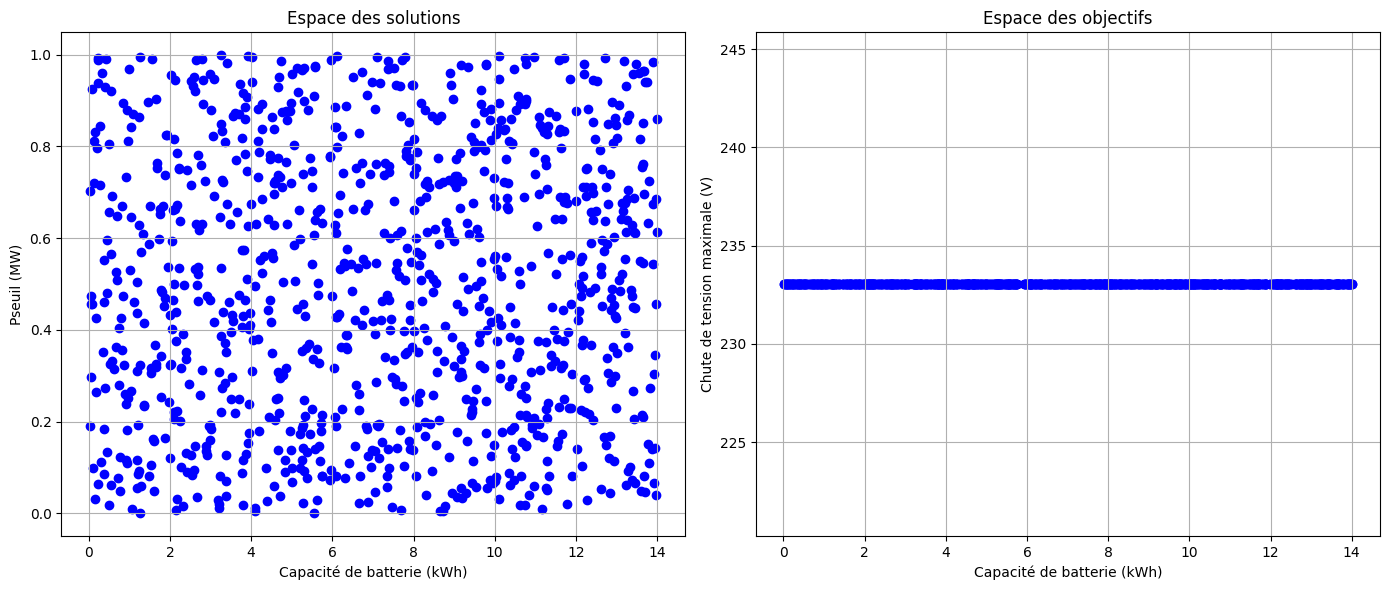

In [23]:
# Étape 1: Fonction pour générer les échantillons aléatoires
def generer_echantillons(n=1000):

    pseuil = np.random.uniform(0, 1.0, n)  # Pseuil entre 0 et 1 MW
    capacite_batterie = np.random.uniform(0, 14, n)  # Capacité entre 0 et 14 kWh
    return pseuil, capacite_batterie

# Fonction principale de simulation pour un échantillon
def simuler_echantillon(Pseuil, capacite_batterie, temps, positions, longueur_ligne, P_bord=0):
    
    rbatterie = 0.9  # Efficacité de la batterie (90%)
    energie_batterie = capacite_batterie  # État initial de la batterie (plein)
    resistances_eq = []  # Liste pour stocker les résistances équivalentes
    V_train_list = []  # Liste pour stocker les tensions aux bornes du train (toutes les valeurs)
    Pseuil = Pseuil * 10**6  # Conversion de MW en W

    # Simulation pour cet échantillon
    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Calcul des résistances entre le train et la sous-station
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1 * R2) / (R1 + R2)  # Résistance équivalente
        resistances_eq.append(R_eq)

        # Calcul de la vitesse et de l'accélération
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]

        vitesse_1 = (positions[i + 1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i + 2] - positions[i + 1]) / dt2 if dt2 != 0 else 0

        acceleration = (vitesse_2 - vitesse_1) / (temps[i + 2] - temps[i + 1]) if i > 0 else 0

        # Calcul de la puissance mécanique et de la puissance totale demandée
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha=0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Gestion de la batterie et de la LAC
        if P_train > Pseuil:
            P_LAC = Pseuil
            capacite_batterie = (P_train - P_LAC) / rbatterie
            energie_batterie -= 0.5 * (capacite_batterie + capacite_batterie) * dt1  # Mise à jour de l'énergie

            if energie_batterie < 0:
                energie_batterie = 0
                capacite_batterie = 0  # Batterie vide
                P_LAC = P_train  # Toute la puissance vient de la LAC
            
        elif 0 < P_train <= Pseuil:
            P_LAC = P_train  # Toute la puissance demandée vient de la LAC
            capacite_batterie = 0  # La batterie n'est pas utilisée
            energie_batterie = energie_batterie  # L'énergie de la batterie reste inchangée

        elif P_train <= 0:
            P_LAC = 0
            if energie_batterie >= capacite_batterie:
                capacite_batterie = 0  # Batterie pleine
                energie_batterie = capacite_batterie  # Mise à jour de l'énergie
            else:
                capacite_batterie = abs(P_train) * rbatterie  # Rechargement de la batterie
                energie_batterie -= 0.5 * (capacite_batterie + capacite_batterie) * dt1
                if energie_batterie > capacite_batterie:
                    energie_batterie = capacite_batterie  # Limitation à la capacité maximale

        # Calcul de la tension aux bornes du train
        V_train = tension_train(P_LAC, R_eq)
        V_train_list.append(V_train)  # Stocke chaque valeur de tension dans la liste

    # Calcul de la chute de tension maximale
    V_s = 790  
    dV_max = max([V_s - V for V in V_train_list])  # dV_max = max(Vsst - V_train)

    return dV_max

# Fonction de Monte Carlo pour exécuter les simulations
def Monte_Carlo(temps, positions, longueur_ligne):

    dV_max_list = []  # Liste pour stocker les chutes de tension maximales
    pseuil, capacite_batterie = generer_echantillons()  # Générer 1000 échantillons

    # Exécution des simulations pour chaque échantillon
    for i in range(1000):
        dV_max = simuler_echantillon(pseuil[i], capacite_batterie[i], temps, positions, longueur_ligne)
        dV_max_list.append(dV_max)
        
    return pseuil, capacite_batterie, dV_max_list

# Fonction pour afficher les résultats
def graphe(pseuil, capacite_batterie, dV_max):

    # Créer une figure
    plt.figure(figsize=(14, 6))

    # Premier graphique : 
    plt.subplot(1, 2, 1)  
    plt.scatter(capacite_batterie, pseuil, color='blue')  # Affichage des points
    plt.title("Espace des solutions")
    plt.xlabel("Capacité de batterie (kWh)")
    plt.ylabel("Pseuil (MW)")
    plt.grid()

    # Deuxième graphique : dV_max vs Capacité de Batterie (subplot 2)
    plt.subplot(1, 2, 2)  
    plt.scatter(capacite_batterie, dV_max, color='blue')  # Affichage des points
    plt.title("Espace des objectifs")
    plt.xlabel("Capacité de batterie (kWh)")
    plt.ylabel("Chute de tension maximale (V)")
    plt.grid()

    # Ajuster l'espacement et afficher les graphiques
    plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
    plt.show()

# 1. Chargement des données
fichier_donnees = "marche.txt"
temps, positions = charger_donnees_train(fichier_donnees)

# 2. Définir les paramètres de la ligne de tramway
longueur_ligne = max(positions)  # Longueur totale de la ligne (en mètres)

# Exécution de la simulation Monte Carlo
ech_pseuil, ech_capa, ech_dV_max = Monte_Carlo(temps, positions, longueur_ligne)

# Affichage des résultats
graphe(ech_pseuil, ech_capa, ech_dV_max)



### Algorithme NGSA2

Maintenant que nous avons compris les notions de solutions non dominées, et solutions Pareto-optimales, nous nous intéresserons à l'implémentation d'un algorithme génétique NGSA2 afin d’essayer de construire l’ensemble des solutions non dominées avec moins d’évaluations de solutions pour déterminer la solution la plus optimale à notre problème.

In [ ]:
# Fonction générique pour tracer un graphique simple
def plot_graph(x, y, xlabel, ylabel, title, color='blue', label=None, grid=True):
    plt.plot(x, y, color=color, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if label:
        plt.legend()
    if grid:
        plt.grid()
    plt.tight_layout()

# Fonction pour mesurer le temps d'exécuton
def chronometrer(fonction):
    def wrapper(*args, **kwargs):
        debut = time.time()
        resultat = fonction(*args, **kwargs)
        fin = time.time()
        print(f"Temps d'exécution de {fonction.__name__}: {fin - debut:.4f} secondes")
        return resultat
    return wrapper

# Fonction pour lire les données depuis le fichier
def lire_donnees(fichier):
    donnees = np.loadtxt(fichier)
    temps, positions = donnees[:, 0], donnees[:, 1]
    return temps, positions


# Fonction pour calculer les résistances
def resistance_eq(param_reseau, position_train):
    position_train = np.clip(position_train, param_reseau["pos_debut"], param_reseau["pos_fin"])
    dist_debut = position_train - param_reseau["pos_debut"]
    dist_fin = param_reseau["pos_fin"] - position_train
    rail1 = param_reseau["rho_rail"] * dist_debut
    rail2 = param_reseau["rho_rail"] * dist_fin
    ligne1 = param_reseau["rho_ligne"] * dist_debut
    ligne2 = param_reseau["rho_ligne"] * dist_fin
    branche1 = param_reseau["resistance_sst"] + rail1 + ligne1
    branche2 = param_reseau["resistance_sst"] + rail2 + ligne2
    res_totale = branche1 * branche2 / (branche1 + branche2)
    return res_totale, branche1, branche2


# Fonction pour calculer la puissance du système
def puissance_systeme(param_train, positions, delta_temps):
    coeff0 = param_train["C0"] + param_train["C1"] * param_train["masse"]
    coeff1 = param_train["B0"] + param_train["B1"] * param_train["masse"]
    coeff2 = param_train["A0"] + param_train["A1"] * param_train["masse"]
    masse_train = param_train["masse"]
    rendement = param_train["rendement"]
    vitesse = np.gradient(positions, delta_temps)
    acceleration = np.gradient(vitesse, delta_temps)
    force = masse_train * acceleration + coeff0 + coeff1 * vitesse + coeff2 * vitesse**2
    puissance_meca = force * vitesse
    puissance_elec = np.where(
        puissance_meca < 0,
        puissance_meca * rendement,  
        puissance_meca / rendement  
    )
    puissance_elec += param_train["puissance_aux"]
    return puissance_elec, vitesse, force


# Fonction pour déterminer la tension du train
def tension_train(param_reseau, positions, puissances):
    res_totale, _, _ = resistance_eq(param_reseau, positions)
    discriminant = param_reseau["tension_sst"]**2 - 4 * res_totale * puissances
    tension = np.where(
        discriminant >= 0,
        0.5 * (param_reseau["tension_sst"] + np.sqrt(discriminant)),
        0.5 * param_reseau["tension_sst"]
    )
    erreurs = np.where(discriminant < 0)[0]
    return tension, erreurs


# Fonction pour simuler la batterie
def gestion_batterie(param_reseau, param_train, positions, puissances, delta_temps):
    res_totale, _, _ = resistance_eq(param_reseau, positions)
    batterie_charge = np.zeros(len(positions) + 1)
    batterie_charge[0] = 0.9 * param_train["cap_batterie_max"]
    puissance_batterie = np.zeros(len(positions))
    puissance_ligne = np.zeros(len(positions))
    puissance_exces = np.zeros(len(positions))
    tension = np.zeros_like(positions)
    erreurs = []
    for index in range(len(positions)):
        if puissances[index] < 0:
            batterie_test = puissances[index]
        else:
            batterie_test = puissances[index] - param_train["limite_ligne"]
        charge_test = batterie_charge[index] - batterie_test * delta_temps
        batterie_charge[index + 1] = np.clip(charge_test, 0, param_train["cap_batterie_max"])
        puissance_batterie[index] = (batterie_charge[index] - batterie_charge[index + 1]) / delta_temps
        if puissances[index] > puissance_batterie[index]:
            puissance_ligne[index] = puissances[index] - puissance_batterie[index]
        elif puissances[index] < puissance_batterie[index]:
            puissance_exces[index] = puissance_batterie[index] - puissances[index]
        discriminant = param_reseau["tension_sst"]**2 - 4 * res_totale[index] * puissance_ligne[index]
        if discriminant >= 0:
            tension[index] = 0.5 * (param_reseau["tension_sst"] + np.sqrt(discriminant))
        else:
            tension[index] = 0.5 * param_reseau["tension_sst"]
            erreurs.append(index)
    return tension, erreurs, puissance_batterie, batterie_charge, puissance_ligne, puissance_exces


# Fonction de calcul de la performance du système
def calcule_performance(param_reseau, param_train, positions, puissances, dt):
    tensions_train, erreurs, P_batt, E_batt, P_lac, P_rheostat = gestion_batterie(
        param_reseau, param_train, positions, puissances, dt
    )
    R_eq, R1, R2 = resistance_eq(param_reseau, positions)
    delta_tensions = param_reseau["tension_sst"] - tensions_train
    i_1 = delta_tensions / R1
    i_2 = delta_tensions / R2
    P_sst = param_reseau["tension_sst"] * (i_1 + i_2)
    E_sst = np.cumsum(P_sst) * dt
    E_tot = E_sst + (E_batt[0] - E_batt[-1])
    chute_tension = param_reseau["tension_sst"] - tensions_train
    dv_max = np.max(chute_tension)
    return E_tot, dv_max


# Paramètres du train et du réseau
param_train = {
    "A0": 780, "A1": 6.4, "B0": 0, "B1": 0.14, "C0": 0.3634, "C1": 0,
    "masse": 70000, "rendement": 0.8, "puissance_aux": 35000,
    "cap_batterie_max": 1e8, "limite_ligne": 1e6
}
param_reseau = {
    "rho_rail": 95e-6, "rho_ligne": 10e-6, "pos_debut": 0, "pos_fin": 5000,
    "resistance_sst": 0.033, "tension_sst": 790
}

# Lecture des données
file_path = 'marche.txt'  # Nom du fichier à remplacer si nécessaire
temps, positions = lire_donnees(file_path)
delta_temps = np.mean(np.diff(temps))

# Simulation sans batterie
puissances, vitesses, forces = puissance_systeme(param_train, positions, delta_temps)
tensions, _ = tension_train(param_reseau, positions, puissances)
puissance_sst = param_reseau["tension_sst"]**2 / tensions

# Simulation avec batterie
tensions_batterie, _, puissance_batt, charge_batt, puissance_ligne, exces = gestion_batterie(
    param_reseau, param_train, positions, puissances, delta_temps)

# Calcul de la performance du système 
E_tot, dv_max = calcule_performance(param_reseau, param_train, positions, puissances, delta_temps)

# Affichage des résultats de performance
#print("Énergie totale :", E_tot)
print("Chute de tension maximale :", dv_max)


@chronometrer
def simulation_monte_carlo(reseau, train, positions, delta_t, n_simulations):
    capacites_batterie = np.random.uniform(1e6, 1e8, n_simulations)
    seuils_puissance = np.random.uniform(1e5, 1e6, n_simulations)
    chutes_tension_max = np.zeros(n_simulations)
    for i in range(n_simulations):
        train_sim = train.copy()
        train_sim["cap_batterie_max"] = capacites_batterie[i]
        train_sim["limite_ligne"] = seuils_puissance[i]
        tensions, _, _, _, _, _ = gestion_batterie(reseau, train_sim, positions, puissances, delta_t)
        chutes_tension_max[i] = np.max(reseau["tension_sst"] - tensions)
    return capacites_batterie, chutes_tension_max, seuils_puissance

# Extraction du front de Pareto
def extraire_front_pareto(capacites, chutes, seuils):
    indices_tris = np.argsort(capacites)

    capacites_triees = capacites[indices_tris]
    chutes_triees = chutes[indices_tris]
    seuils_tries = seuils[indices_tris]

    front_pareto = [0] 
    for i in range(1, len(capacites_triees)):
        if chutes_triees[i] < chutes_triees[front_pareto[-1]]:
            front_pareto.append(i)

    return capacites_triees[front_pareto], chutes_triees[front_pareto], seuils_tries[front_pareto]

# Simulation Monte-Carlo
# Données simulées
n_simulations = 1000
delta_temps = 1  
positions = np.linspace(0, 5000, 1000)  
puissances = np.random.uniform(1e5, 1e6, len(positions))  

# Simulation
capacites, chutes, seuils = simulation_monte_carlo(param_reseau, param_train, positions, delta_temps, n_simulations)
capacites_pareto, chutes_pareto, seuils_pareto = extraire_front_pareto(capacites, chutes, seuils)

# Visualisation
plt.figure(figsize=(12, 5))

# Espace des solutions
plt.subplot(1, 2, 1)
plt.scatter(capacites / 6e6, seuils / 1e3, c='blue', alpha=0.5, label="Solutions générées")
plt.scatter(capacites_pareto / 6e6, seuils_pareto / 1e3, c='orange', label="Front de Pareto")
plt.xlabel("Capacité batterie [kWh]")
plt.ylabel("Seuil [kW]")
plt.title("Espace des solutions")
plt.legend()
plt.grid(True)

# Espace des objectifs
plt.subplot(1, 2, 2)
plt.scatter(capacites / 6e6, chutes, c='blue', alpha=0.5, label="Solutions générées")
plt.scatter(capacites_pareto / 6e6, chutes_pareto, c='orange', label="Front de Pareto")
plt.xlabel("Capacité batterie [kWh]")
plt.ylabel("ΔV max [V]")
plt.title("Espace des objectifs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualisation des résultats Monte-Carlo
plt.figure(figsize=(12, 8))

# Scatter plot des solutions générées
plt.subplot(2, 1, 1)
plt.scatter(capacites / 6e6, chutes, label="Solutions générées", color="blue", alpha=0.5)
plt.plot(capacites_pareto / 6e6, chutes_pareto, label="Front de Pareto", color="red", marker="o")
plt.xlabel("Capacité de la batterie (MJ)")
plt.ylabel("Chute de tension maximale (V)")
plt.title("Optimisation Monte-Carlo : Capacité vs Chute de Tension")
plt.legend()
plt.grid(True)

# Affichage
plt.tight_layout()
plt.show()